# 4. Slug Test - Dawsonville confined aquifer example

**This test is taken from example of MLU.**

### Import packages

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ttim as ttm

plt.rcParams["figure.figsize"] = [5, 3]

### Introduction and Conceptual Model

In this notebook, we reproduce the work of Yang (2020) to check the TTim performance in analysing slug-test. We later compare the solution in TTim with the MLU model (Carlson & Randall, 2012).

This Slug Test was reported in Cooper Jr et al. (1967), and it was performed in Dawsonville, Georgia, USA. A fully penetrated well (Ln-2) is screened in a confined aquifer, located between depths 24 and 122 (98 m thick).

The volume of the slug is 10.16 litres. Head change has been recorded at the slug well. Both the well and the casing radii of the slug well is 0.076 m.

The conceptual model can be seen in the figure below:

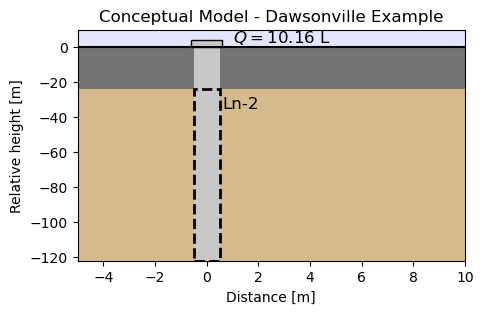

In [13]:
import matplotlib.pyplot as plt

##Now printing the conceptual model figure:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# sky
sky = plt.Rectangle((-5, 0), width=15, height=10, fc="b", zorder=0, alpha=0.1)
ax.add_patch(sky)

# Aquifer:
ground = plt.Rectangle(
    (-5, -122),
    width=15,
    height=98,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(ground)

well = plt.Rectangle(
    (-0.5, -(122)), width=1, height=122, fc=np.array([200, 200, 200]) / 255, zorder=1
)
ax.add_patch(well)

# Confining Unit
conf = plt.Rectangle(
    (-5, -24),
    width=15,
    height=24,
    fc=np.array([100, 100, 100]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(conf)

# Wellhead
wellhead = plt.Rectangle(
    (-0.6, 0), width=1.2, height=4, fc=np.array([200, 200, 200]) / 255, zorder=2, ec="k"
)
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-0.5, -(122)),
    width=1,
    height=98,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen.set_linewidth(2)
ax.add_patch(screen)
# pumping_arrow = plt.Arrow(x = 1,y = 1.5, dx = 0, dy = 1, color = "#00035b")
# ax.add_patch(pumping_arrow)
ax.text(x=1, y=2.5, s=r"$ Q = 10.16$ L", fontsize="large")


# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="k")
ax.add_line(line)

# Water table
# wt = plt.Line2D(xdata= [-200,1200], ydata = [0,0], color = "b")
# ax.add_line(wt)

ax.text(0.6, -35, s="Ln-2", fontsize="large")
# ax.text(6.9, -0.5, "Ln-3", fontsize = 'large')
ax.set_xlim([-5, 10])
ax.set_ylim([-122, 10])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Relative height [m]")
ax.set_title("Conceptual Model - Dawsonville Example");

### Set basic parameters

In [3]:
b = 98  # aquifer thickness, m
zt = -24  # top of aquifer, m
zb = zt - b  # bottom of aquifer, m
rw = 0.076  # well radius of Ln-2 Well, m
rc = 0.076  # casing radius of Ln-2 Well, m
Q = 0.01016  # slug volume in m^3, m

### Load data

Data for the Dawsonville test is available in a text file, where the first column is the time data, in days and in the second column is the head displacement in meters

In [4]:
data = np.loadtxt("data/dawsonville_slug.txt")
to = data[:, 0]
ho = data[:, 1]

### Create First Model - single layer

We begin with a single layer model built in ModelMaq.
Details on setting up the model can be seen in: [Confined 1 - Oude Korendijk](confined1_oude_korendijk.ipynb).

The slug well is set accordingly. Details on setting up the ```Well``` object can be seen in: [Slug 1 - Pratt County](slug1_pratt_county.ipynb).

In [5]:
ml = ttm.ModelMaq(kaq=10, z=[zt, zb], Saq=1e-4, tmin=1e-6, tmax=1e-3, topboundary="conf")
w = ttm.Well(ml, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, -Q)], layers=0, wbstype="slug")
ml.solve()

self.neq  1
solution complete


### Model calibration both simultaneous wells


The procedures for calibration can be seen in [Unconfined 1 - Vennebulten](unconfined1_vennebulten.ipynb)

We calibrate hydraulic conductivity and specific storage, as in the KGS model (Hyder et al. 1994).

In [6]:
# unknown parameters: kay, Saq
ca = ttm.Calibrate(ml)
ca.set_parameter(name="kaq0", initial=10, pmin=0)
ca.set_parameter(name="Saq0", initial=1e-4)
ca.seriesinwell(name="obs", element=w, t=to, h=ho)
ca.fit()

................................
Fit succeeded.


In [7]:
display(ca.parameters)
print("rmse:", ca.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,0.420970,0.018381,4.366247,0.0,inf,10.0000,[0.42096992918521536]
Saq0,0.000017,0.000005,31.133619,-inf,inf,0.0001,[1.698434412425383e-05]


rmse: 0.004409603758298554


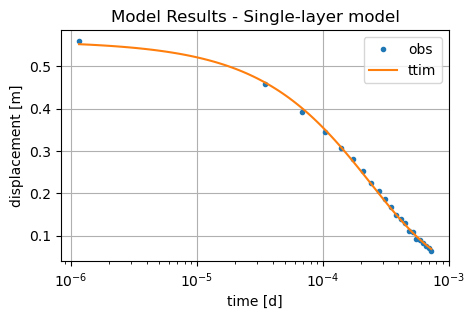

In [8]:
tm = np.logspace(np.log10(to[0]), np.log10(to[-1]), 100)
hm = ml.head(0, 0, tm)
plt.semilogx(to, ho, ".", label="obs")
plt.semilogx(tm, hm[0], label="ttim")
plt.xlabel("time [d]")
plt.ylabel("displacement [m]")
plt.title("Model Results - Single-layer model")
plt.legend()
plt.grid()

In general, the single-layer model seems to be performing well, with a good visual fit between observations and the model.

### Analysis and comparison of simulated values

We now compare the values in TTim and add the results of the modelling done in MLU by Yang (2020).

In [11]:
ta = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]"],
    index=["MLU", "ttim"],
)
ta.loc["MLU"] = [0.4133, 1.9388e-05]
ta.loc["ttim"] = ca.parameters["optimal"].values
ta["RMSE"] = [0.004264, ca.rmse()]
ta.style.set_caption("Comparison of parameter values and error under different models")

,k [m/d],Ss [1/m],RMSE
MLU,0.413300,0.000019,0.004264
ttim,0.420970,0.000017,0.004410


Results are similar between both models. The RMSE of MLU is slightly better than the one from TTim.

### References

* Cooper Jr, H.H., Bredehoeft, J.D., Papadopulos, I.S., 1967. Response of a finite diameter well to an instantaneous charge of water. Water Resources Research 3, 263–269
* Hyder, Z., Butler Jr, J.J., McElwee, C.D., Liu, W., 1994. Slug tests in partially penetrating wells. Water Resources Research 30, 2945–2957.
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.